# Topic Modeling: Latent Semantic Analysis/Indexing

Latent Semantic Analysis set out to improve the results of queries that omitted relevant documents containing synonyms of query terms. Its aimed to model the relationships between documents and terms to be able to predict that a term should be associated with a document, even though, because of variability in word use, no such association was observed.

LSI uses linear algebra to find a given number k of latent topics by decomposing the DTM. More specifically, it uses the Singular Value Decomposition (SVD) to find the best lower-rank DTM approximation using k singular values & vectors. In other words, LSI is an application of the unsupervised learning techniques of dimensionality reduction we encountered in chapter 12 (with some additional detail). The authors experimented with hierarchical clustering but found it too restrictive to explicitly model the document-topic and topic-term relationships or capture associations of documents or terms with several topics.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
from random import randint
import numpy as np
import pandas as pd

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('white')

## Load BBC data

We will illustrate the application of LSI using the BBC articles data that we introduced in the last chapter (13) because they are both small to permit quick training and allow us to compare topic assignments to category labels.

In [4]:
# change to your data path if necessary
DATA_DIR = Path('../data')

In [5]:
path = DATA_DIR / 'bbc'
files = sorted(list(path.glob('**/*.txt')))
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

### Convert to DataFrame

In [6]:
docs = pd.DataFrame(doc_list, columns=['Category', 'Heading', 'Article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2225 non-null   object
 1   Heading   2225 non-null   object
 2   Article   2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


## Create Train & Test Sets

We begin by loading the documents and creating a train and (stratified) test set with 50 articles. Then, we vectorize the data using the TfidfVectorizer to obtain weighted DTM counts and filter out words that appear in less than 1% or more than 25% of the documents as well as generic stopwords to obtain a vocabulary of around 2,900 words:

In [7]:
train_docs, test_docs = train_test_split(docs,
                                         stratify=docs.Category,
                                         test_size=50,
                                         random_state=42)

In [8]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [9]:
pd.Series(test_docs.Category).value_counts()

Category
Sport            12
Business         11
Entertainment     9
Tech              9
Politics          9
Name: count, dtype: int64

### Vectorize train & test sets

In [10]:
vectorizer = TfidfVectorizer(max_df=.25,
                             min_df=.01,
                             stop_words='english',
                             binary=False)
train_dtm = vectorizer.fit_transform(train_docs.Article)
train_dtm

<2175x2917 sparse matrix of type '<class 'numpy.float64'>'
	with 210043 stored elements in Compressed Sparse Row format>

In [11]:
test_dtm = vectorizer.transform(test_docs.Article)
test_dtm

<50x2917 sparse matrix of type '<class 'numpy.float64'>'
	with 4758 stored elements in Compressed Sparse Row format>

In [43]:
train_dtm.sum(0).A


matrix([[30.2763503 ,  3.88061107, 21.80434011, ...,  3.19176144,
         11.37172901,  5.49322844]])

### Get token count

In [13]:
train_token_count = train_dtm.sum(0).A.squeeze()
tokens = vectorizer.get_feature_names_out()
word_count = pd.Series(train_token_count,
                       index=tokens).sort_values(ascending=False)
word_count.head(10)

film          41.256270
government    38.808175
game          36.319726
best          36.093477
uk            36.082515
labour        32.496474
music         30.706548
000           30.276350
company       29.549555
number        29.153795
dtype: float64

## Latent Semantic Analysis

We use sklearn’s TruncatedSVD class that only computes the k largest singular values to reduce the dimensionality of the document-term matrix. The deterministic arpack algorithm delivers an exact solution but the default ‘randomized’ implementation is more efficient for large matrices. 

We compute five topics to match the five categories, which explain only 5.4% of the total DTM variance so higher values would be reasonable.

In [14]:
n_components = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components + 1)]

In [15]:
svd = TruncatedSVD(n_components=n_components, n_iter=5, random_state=42)
svd.fit(train_dtm)

TruncatedSVD(n_components=5, random_state=42)

In [16]:
svd.singular_values_

array([8.90935604, 5.71762755, 5.38197939, 5.04420678, 4.71440144])

In [17]:
svd.explained_variance_ratio_.sum()

0.053823572860572794

### Explore Topics 

LSI identifies a new orthogonal basis for the document-term matrix that reduces the rank to the number of desired topics. 

The `.transform()` method of the trained svd object projects the documents into the new topic space that is the result of reducing the dimensionality of the document vectors and corresponds to the UTΣT transformation explained in the book.

In [18]:
train_doc_topics = svd.transform(train_dtm)

In [19]:
train_doc_topics.shape

(2175, 5)

#### Topic Weights for sample article

We can sample an article to view its location in the topic space. We draw a ‘Politics’ article that is most (positively) associated with topics 1 and 2 (and 3):

In [27]:
i = randint(0, len(train_docs))
(train_docs.iloc[i, :2].concat(
    pd.Series(train_doc_topics[i], index=topic_labels)))

AttributeError: 'Series' object has no attribute 'concat'

#### Average topic weight per category

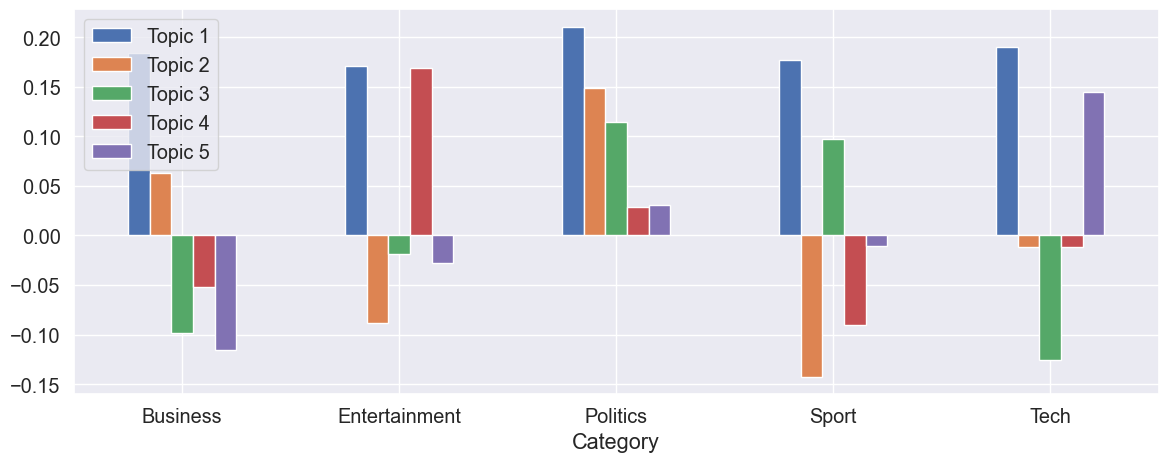

In [28]:
train_result = pd.DataFrame(data=train_doc_topics,
                            columns=topic_labels,
                            index=train_docs.Category)
train_result.groupby(level='Category').mean().plot.bar(figsize=(14, 5), rot=0);

#### Topics weights of most frequent words

In [29]:
topics = pd.DataFrame(svd.components_.T, index=tokens, columns=topic_labels)
topics.loc[word_count.head(10).index]

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
film,0.096117,-0.157755,-0.037131,0.456760,-0.108419
government,0.105821,0.158542,0.050579,0.000476,-0.032035
game,0.092472,-0.165604,0.074222,-0.112915,0.056594
best,0.088036,-0.148498,0.019054,0.264735,-0.091923
uk,0.092431,0.030233,-0.055868,0.041345,0.012776
labour,0.100164,0.237937,0.227080,0.071624,0.054642
music,0.078805,-0.050253,-0.114264,0.080930,0.140046
000,0.073360,0.029985,-0.044699,0.003032,-0.013678
company,0.067638,0.024084,-0.102071,-0.028465,-0.053378
number,0.070099,-0.039725,-0.019470,0.030363,0.003596


#### Most important words by topic

We can also display the words that are most closely associated with each topic (in absolute terms). The topics appear to capture some semantic information but are not clearly differentiated

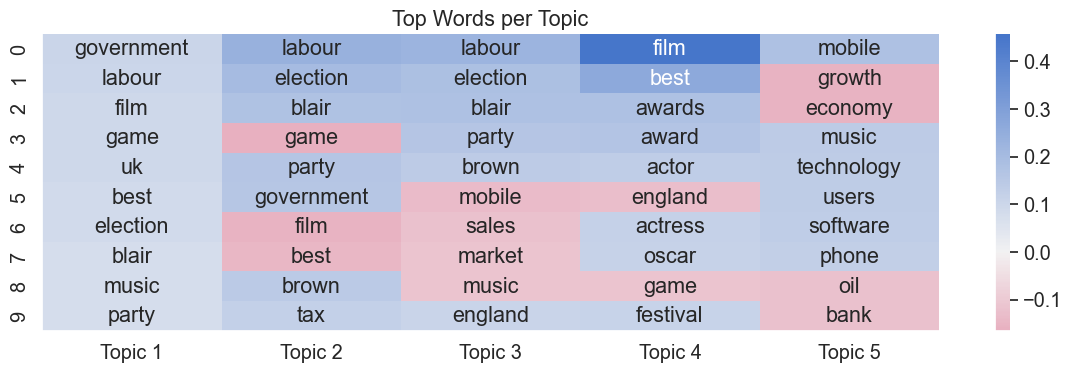

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))
top_words, top_vals = pd.DataFrame(), pd.DataFrame()
for topic, words_ in topics.items():
    top10 = words_.abs().nlargest(10).index
    vals = words_.loc[top10].values
    top_vals[topic] = vals
    top_words[topic] = top10.tolist()
sns.heatmap(pd.DataFrame(top_vals),
            annot=top_words,
            fmt='',
            center=0,
            cmap=sns.diverging_palette(0, 255, sep=1, n=256),
            ax=ax)
ax.set_title('Top Words per Topic')
sns.despine()
fig.tight_layout()

#### Topics weights for test set

The topic assignments for this sample align with the average topic weights for each category illustrated below (Politics is the leftmost). They illustrate how LSI expresses the k topics as directions in a k-dimensional space (below you find a projection of the average topic assignments per category into two-dimensional space). 

Each category is clearly defined, and the test assignments match with train assignments. However, the weights are both positive and negative, making it more difficult to interpret the topics.

In [31]:
test_eval = pd.DataFrame(data=svd.transform(test_dtm),
                         columns=topic_labels,
                         index=test_docs.Category)

In [33]:
train_result.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
Category,,,,,
Entertainment,0.139485,-0.072225,-0.010679,0.162038,-0.018796
Tech,0.161388,0.035496,-0.099653,-0.027510,0.176396
Entertainment,0.138279,-0.065188,0.001179,0.097927,-0.045589
Business,0.184543,0.057818,-0.078343,-0.044610,-0.091778
Sport,0.170239,-0.115598,0.074803,-0.034476,-0.052675


In [34]:
test_eval.assign(Data='Test')

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Data
Category,,,,,,
Entertainment,0.193436,-0.140766,-0.043558,0.331671,-0.103252,Test
Tech,0.140262,0.011729,-0.061302,-0.017357,0.079385,Test
Tech,0.202437,0.026641,-0.161363,-0.037740,0.205128,Test
Business,0.150145,0.043118,-0.084560,-0.037672,-0.074187,Test
Sport,0.146748,-0.075206,0.052537,-0.078677,-0.010577,Test
Business,0.220862,-0.074283,-0.002470,-0.086017,-0.041031,Test
Business,0.237265,0.080153,-0.127809,-0.069183,-0.135020,Test
Sport,0.198524,-0.217735,0.153088,-0.160805,-0.020480,Test
Business,0.188855,0.092879,-0.121556,-0.082890,-0.195180,Test


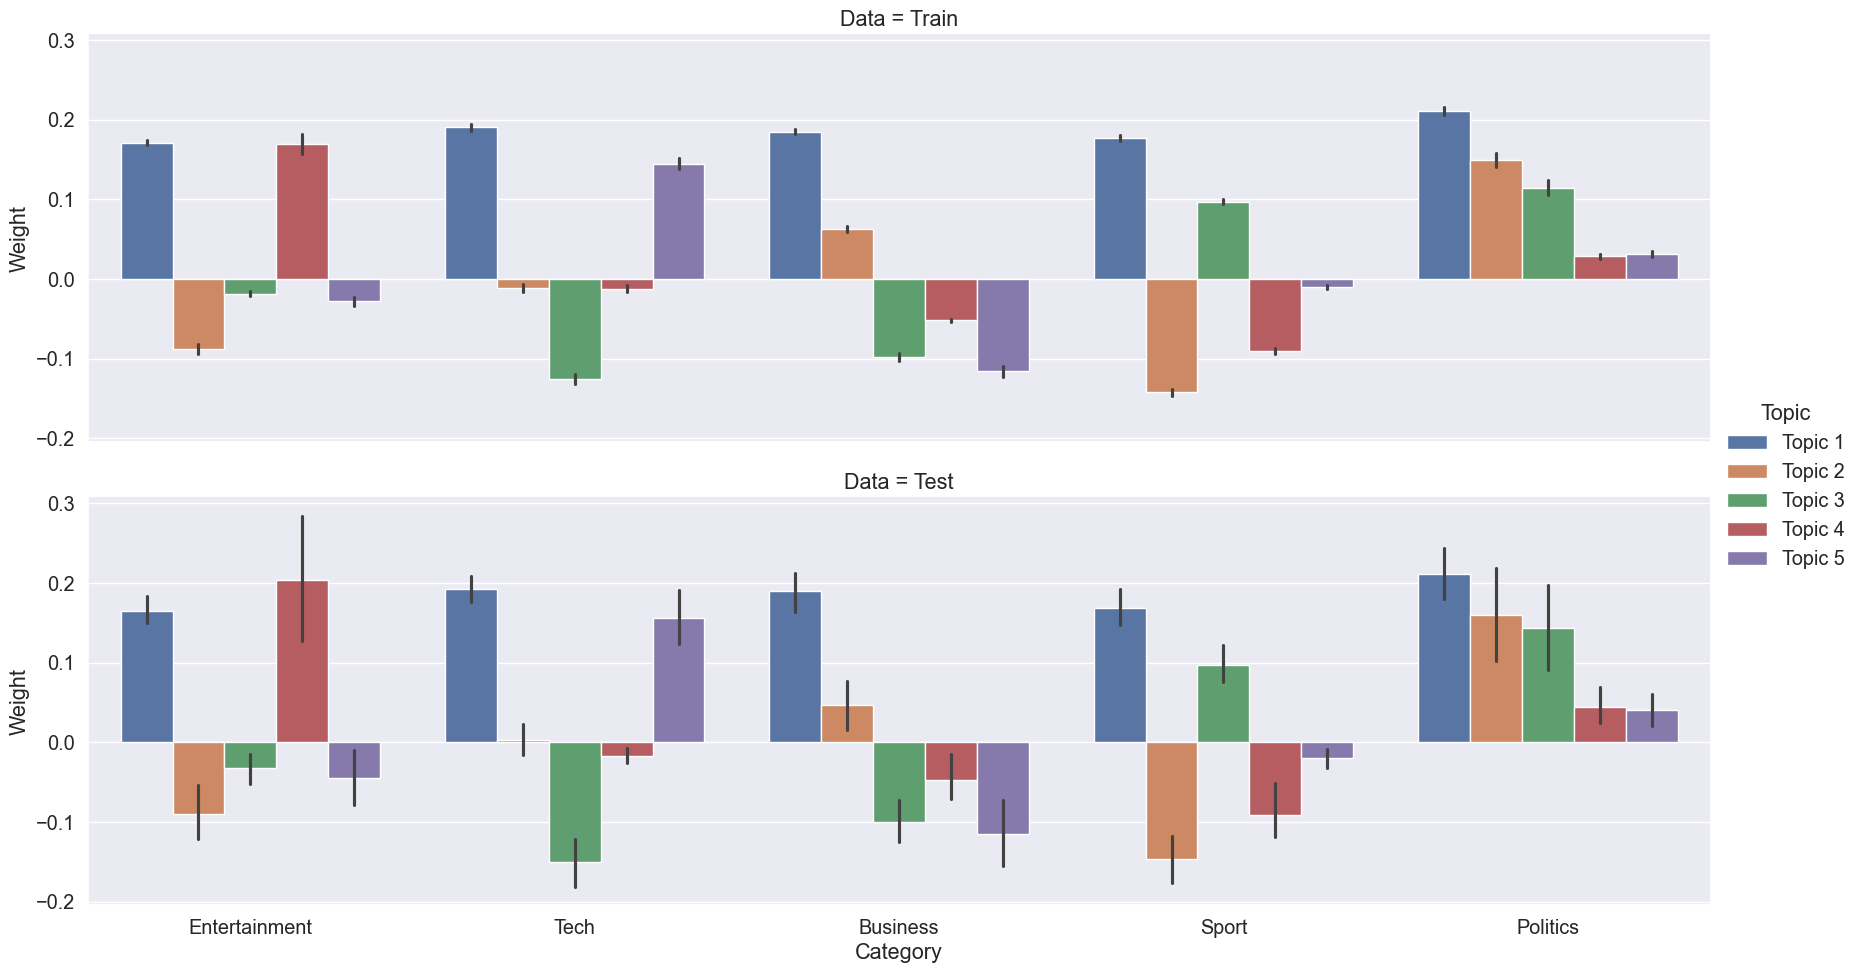

In [39]:
sns.set(font_scale=1.3)
result = pd.melt(pd.concat([train_result.assign(Data='Train'), test_eval.assign(Data='Test')]).reset_index(),
                 id_vars=['Data', 'Category'],
                 var_name='Topic',
                 value_name='Weight')

g = sns.catplot(x='Category',
                y='Weight',
                hue='Topic',
                row='Data',
                kind='bar',
                data=result,
                aspect=3.5);

### Categories in 2D

The below plot shows the projections of the five topics into a 2D space.

In [40]:
pca = PCA(n_components=2)
svd2d = pd.DataFrame(pca.fit_transform(train_result),
                     columns=['PC1',
                              'PC2']).assign(Category=train_docs.Category)
categories_2d = svd2d.groupby('Category').mean()

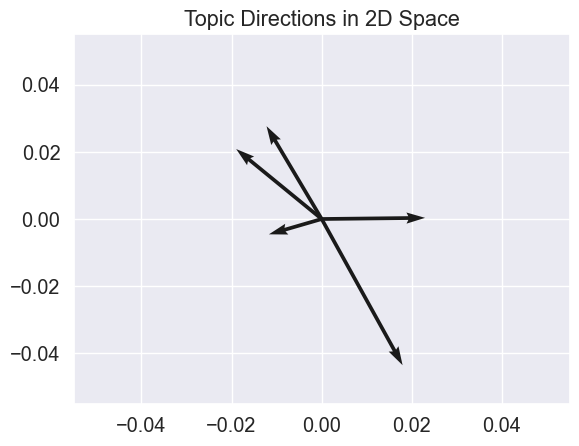

In [41]:
plt.quiver(np.zeros(5),
           np.zeros(5),
           categories_2d.PC1.values,
           categories_2d.PC2.values,
           scale=.035)
plt.title('Topic Directions in 2D Space');

## Strenghts & Weaknesses

The benefits of LSI include the removal of noise and mitigation of the curse of dimensionality, while also capturing some semantics and performing a clustering of both documents and terms.

However, the results of LSI are difficult to interpret because topics are word vectors with both positive and negative entries. In addition, there is no underlying model that would permit the evaluation of fit and provide guidance when selecting the number of dimensions or topics.